Setup of code:

- Generate timeseries for a coupled oscillator system, with adjustable coupling
- Compute the R, S and TSE components
- Normalize the R and S values so that they can be mapped onto the TSE heatmap
- Map the trajectories for a variety of coupling factors.

Expectation:
If the system does not exhibit synergistic interactions, then trajectory will just be a straight line accross the redundancy axis, from 0 to max with decreasing TSE. The coupling factor is then proportional to the speed of the trajectory. However, we want to visualise a trajectory that includes synergistic interactions.

Solution/checkup:
Check if the coupled oscillator system exhibits synergy.

In [3]:
# LIBRARIES
import pandas as pd
from sklearn.utils import Bunch
import infotopo
import numpy as np
import random
import matplotlib.pyplot as plt

In [128]:
# FUNCTIONS

# Convert a given pandas dataframe to a Bunch object
def dataframe_to_bunch(dataframe, target=None, feature_names=None, target_names=None, descr="Custom dataset"):
    if feature_names is None:
        feature_names = dataframe.columns.tolist()
    
    return Bunch(
        data=dataframe.to_numpy(),
        target=target if target is not None else np.zeros(dataframe.shape[0]),
        feature_names=feature_names,
        target_names=target_names if target_names is not None else ["target"],
        DESCR=descr
    )

# Function to obtain the metrics from the infotopo module
def obtain_infotopo_metrics(dataset):
    
    dimension_max = 10 #dataset.shape[1]
    dimension_tot = dataset.shape[1]
    sample_size = dataset.shape[0]
    nb_of_values = 16
    forward_computation_mode = True
    work_on_transpose = False
    supervised_mode = False
    sampling_mode = 1
    deformed_probability_mode = False

    information_topo = infotopo.infotopo(dimension_max = dimension_max,
                                dimension_tot = dimension_tot,
                                sample_size = sample_size,
                                work_on_transpose = work_on_transpose,
                                nb_of_values = nb_of_values,
                                sampling_mode = sampling_mode,
                                deformed_probability_mode = deformed_probability_mode,
                                supervised_mode = supervised_mode,
                                forward_computation_mode = forward_computation_mode)
    
    Nentropie = information_topo.simplicial_entropies_decomposition(dataset) # Make sure the datatype is a Bunch object
    Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)
    #Nfree_energy = information_topo.total_correlation_simplicial_lanscape(Nentropie)
    
    return  Nentropie, Ninfomut

# Function to generate metrics from given timeseries by sliding window
def interactions_values(df_input):
    # Initialize an empty DataFrame
    columns = ['R_sum', 'S_sum', 'TSE_value']
    df_output = pd.DataFrame(columns=columns)

    # Set initial window conditions
    window_start = 0
    window_end = window_start + 100

    while window_end < len(df_input):
        bunch_data = dataframe_to_bunch(df_input.iloc[window_start:window_end])
        Nentropie, Ninfomut = obtain_infotopo_metrics(bunch_data.data)
        S_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value < 0)
        R_sum = sum(value for key, value in Ninfomut.items() if len(key) > 2 and value > 0)
        TSE_value = compute_tse_complexity(Ninfomut)

        # Add the new values to the dataframe
        new_row = pd.DataFrame({'R_sum': [R_sum], 'S_sum': [S_sum], 'TSE_value': [TSE_value]})
        df_output = pd.concat([df_output, new_row], ignore_index=True)
        
        window_start += 100
        window_end += 100

    # Normalize and absolutize all the values so that the S and R values are all positive and the maximum R and S are 1.
    df_output.iloc[:, 1] = df_output.iloc[:, 1] * -1

    max_R = df_output.iloc[:, 0].max()
    max_S = df_output.iloc[:, 1].max()

    if max_S > 0:
        df_output.iloc[:, 1] = df_output.iloc[:, 1] / max_S        
    if max_R > 0:
        df_output.iloc[:, 0] = df_output.iloc[:, 0] / max_R

    return df_output

# Function to compute TSE complexity
def compute_tse_complexity(TC_dict):
    """Compute TSE complexity efficiently."""
    N = max(len(subset) for subset in TC_dict)  # Maximum subset size
    TSE = 0
    for gamma in range(1, N):
        TC_full = (gamma / N) * TC_dict[tuple(range(1, N + 1))]
        E_TC_gamma = np.mean([TC_dict[subset] for subset in TC_dict if len(subset) == gamma])
        TSE += TC_full - E_TC_gamma
    return TSE

# Function to generate oscillator dynamics for a given number of oscillators
def simulate_coupled_oscillators(num_oscillators, dt=0.01, t_end=200, coupling_factor=0.1, output_file="Data\\time_series_coupled_oscillator.txt"):
    """
    Simulates a system of coupled oscillators.

    Parameters:
        num_oscillators (int): Number of oscillators in the system.
        dt (float): Time step for the simulation.
        t_end (float): End time for the simulation.
        initial_phases (list or np.ndarray): Initial phases of the oscillators. If None, defaults to zeros.
        natural_frequencies (list or np.ndarray): Natural frequencies of the oscillators. If None, defaults to ones.
        coupling_factor (float): Coupling strength between oscillators.
        output_file (str): Path to save the time series data.

    Returns:
        np.ndarray: Time series of the oscillators' phases.
    """
    # Set initial conditions
    pi_list = [np.pi for _ in range(num_oscillators)]
    random_numbers = [random.random() for _ in range(len(pi_list))]
    initial_phases = [value * rand for value, rand in zip(pi_list, random_numbers)]
    natural_frequencies = [random.random() for _ in range(num_oscillators)]

    # Time array
    time = np.arange(0, t_end, dt)
    num_steps = len(time)

    # Validate input lengths
    if len(initial_phases) != num_oscillators or len(natural_frequencies) != num_oscillators:
        raise ValueError("Length of initial_phases and natural_frequencies must match num_oscillators.")

    # Initialize arrays to store results
    theta_series = np.zeros((num_steps, num_oscillators))
    theta_series[0, :] = initial_phases

    # Simulate the coupled oscillator system
    for i in range(1, num_steps):
        for j in range(num_oscillators):
            # Compute coupling term for oscillator j
            coupling = sum(
                coupling_factor * np.sin(theta_series[i-1, k] - theta_series[i-1, j])
                for k in range(num_oscillators) if k != j
            )

            # Update phase using Euler's method
            theta_series[i, j] = theta_series[i-1, j] + (natural_frequencies[j] + coupling) * dt

    # Save the time series data to a text file
    header = " ".join([f"x{k+1}" for k in range(num_oscillators)])
    np.savetxt(output_file, theta_series, header=header, comments="")

    return theta_series

# Generate oscillator dynamics

In [130]:
# Example usage
if __name__ == "__main__":
    num_oscillators = 10
    coupling_factor = 0.02 # 0.01 gives non-synchronized behaviour

    time_series = simulate_coupled_oscillators(
        num_oscillators=num_oscillators,
        dt=0.01,
        t_end=200,
        coupling_factor=coupling_factor
    )

In [131]:
# Load the time series data from the text file into a pandas DataFrame
df_oscillators = pd.read_csv("Data\\time_series_coupled_oscillator.txt", sep=r'\s+')

# Extract the columns as individual series using a loop
series_dict = {}
for i, column_name in enumerate(df_oscillators.columns):
    series_dict[f'theta{i+1}_series'] = df_oscillators.iloc[:, i]

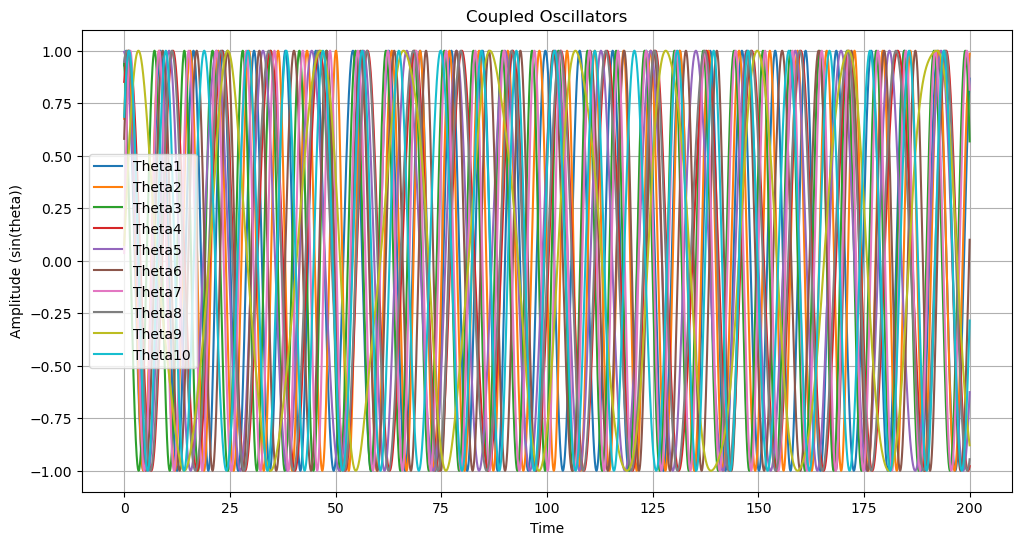

In [132]:
# Generate the time array
time = np.arange(0, 200, 0.01)

# Plot the results
plt.figure(figsize=(12, 6))

# Loop over the theta series in the dictionary
for key, series in series_dict.items():
    plt.plot(time, np.sin(series), label=key.replace('_series', '').capitalize())

# Add plot details
plt.title("Coupled Oscillators")
plt.xlabel("Time")
plt.ylabel("Amplitude (sin(theta))")
plt.legend()
plt.grid()
plt.show()


# Now analyse R, S and TSE for these cases
For each case, use a time sliding window to compute the evolution of R, S and TSE.
That is take a input a timeseries and a timestepsize and give a output a list of R, S and TSE values.

In [133]:
# Load the data from the text files into pandas DataFrames, excluding the 'Time' column

# Load Lotka-Volterra data
synergistic_df = pd.read_csv("Data/synergistic_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
redundant_df = pd.read_csv("Data/redundant_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
mixed_df = pd.read_csv("Data/mixed_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])

# Load random number data
df_random = pd.read_csv("timeseries_test.txt", delim_whitespace=True)

# Load oscillator system
df_oscillators = pd.read_csv("Data\\time_series_coupled_oscillator.txt", delim_whitespace=True)

C:\Users\cyril\AppData\Local\Temp\ipykernel_13028\848317546.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  synergistic_df = pd.read_csv("Data/synergistic_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
C:\Users\cyril\AppData\Local\Temp\ipykernel_13028\848317546.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  redundant_df = pd.read_csv("Data/redundant_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
C:\Users\cyril\AppData\Local\Temp\ipykernel_13028\848317546.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  mixed_df = pd.read_csv("Data/mixed_timeseries.txt", delim_whitespace=True, usecols=[1, 2, 3])
C:\Users\cyril\AppData\Local\Temp\ipykernel_13028\848317546.py:9: Fu

In [ ]:
df = interactions_values(df_oscillators)

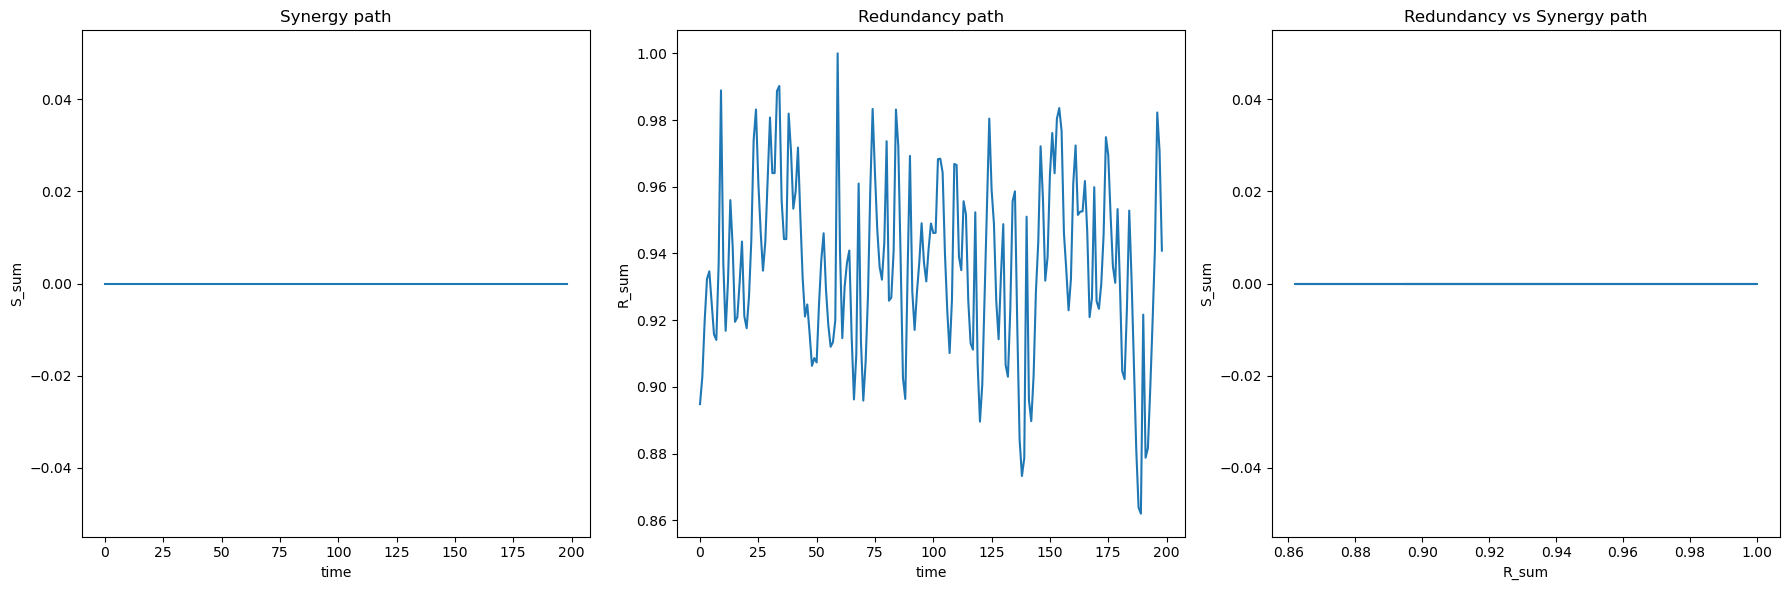

In [135]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.plot(df.index, df['S_sum'])
plt.xlabel('time')
plt.ylabel('S_sum')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.plot(df.index, df['R_sum'])
plt.xlabel('time')
plt.ylabel('R_sum')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.plot(df['R_sum'], -df['S_sum'])
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()

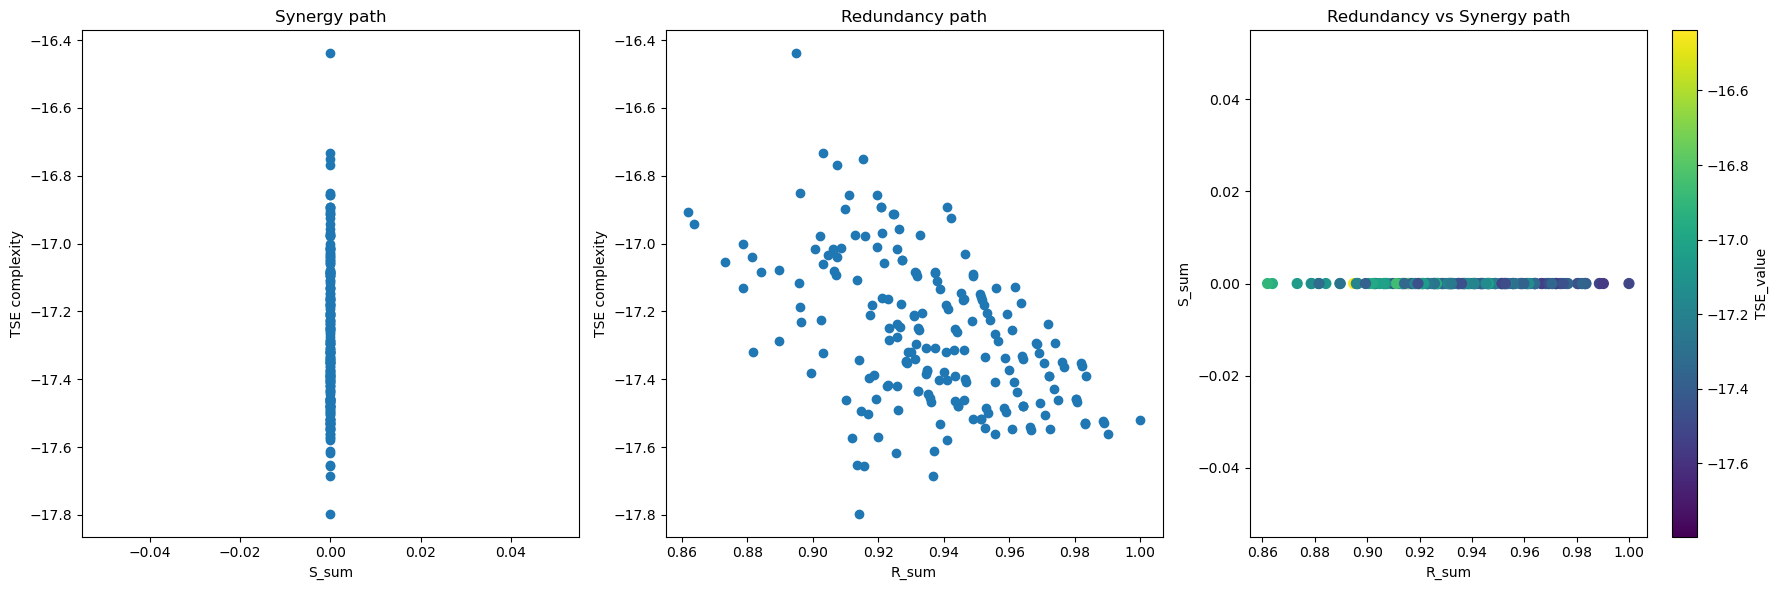

In [136]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))

# First subplot for Synergy path
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.scatter(df['S_sum'], df['TSE_value'])
plt.xlabel('S_sum')
plt.ylabel('TSE complexity')
plt.title('Synergy path')

# Second subplot for Redundancy path
plt.subplot(1, 3, 2)
plt.scatter(df['R_sum'], df['TSE_value'])
plt.xlabel('R_sum')
plt.ylabel('TSE complexity')
plt.title('Redundancy path')

# Third subplot for Redundancy vs Synergy path
plt.subplot(1, 3, 3)
plt.scatter(df['R_sum'], df['S_sum'], c=df['TSE_value'], cmap='viridis', s=50)
plt.colorbar(label='TSE_value')
plt.xlabel('R_sum')
plt.ylabel('S_sum')
plt.title('Redundancy vs Synergy path')

# Adjust layout to avoid overlap and display the plot
plt.tight_layout()
plt.show()